In [56]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
%cd /Users/gjain/Documents/xom

/Users/gjain/Documents/xom


# Project objective: Average house price (WOZ) prediction for an area in Amsterdam

In [58]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

from category_encoders.ordinal import OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from src.utils.constants import TARGET

from category_encoders.ordinal import OrdinalEncoder
import lightgbm as lgb

from src.predictor import (
    check_if_area_is_empty,
    fill_na_values,
    convert_dtypes,
    get_area_borough,
    get_perc_row_totals,
    rename_column_names,
    add_area_name_features,
    add_borough_details,
)

In [59]:
pd.options.display.float_format = "{:.4f}".format
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 99)
pd.set_option("display.max_colwidth", 199)

In [60]:
base_dir = Path("/Users/gjain/Documents/xom")
data = base_dir / "data"

### Reading in training and validation data

In [61]:
X_train = pd.read_parquet(data / "02_intermediate/X_train.csv")
X_valid = pd.read_parquet(data / "02_intermediate/X_valid.csv")
y_train = pd.read_parquet(data / "02_intermediate/y_train.csv")
y_valid = pd.read_parquet(data / "02_intermediate/y_valid.csv")

X_train.head()

,single,married_no_kids,not_married_no_kids,married_with_kids,not_married_with_kids,single_parent,other,total,woz_per_msq,borough,perc_area_single,perc_area_married_no_kids,perc_area_not_married_no_kids,perc_area_married_with_kids,perc_area_not_married_with_kids,perc_area_single_parent,perc_area_other,perc_of_tot_fam_type_single,perc_of_tot_fam_type_married_no_kids,perc_of_tot_fam_type_not_married_no_kids,perc_of_tot_fam_type_married_with_kids,perc_of_tot_fam_type_not_married_with_kids,perc_of_tot_fam_type_single_parent,perc_of_tot_fam_type_other,area_has_buurt,area_has_burg,area_has_dijk,area_has_park,area_has_plein,area_has_nieuw,area_has_gracht,area_has_dorp,Highest_income_hhs,Touristy,Diversity,HasHomeStadium,IsPosh
11,1866.0000,116.0000,270.0000,173.0000,141.0000,491.0000,43.0000,3100.0000,1854.0000,Zuidoost,60.1936,3.7419,8.7097,5.5806,4.5484,15.8387,1.3871,0.8804,0.3170,0.5963,0.3739,0.7444,1.3575,0.7731,False,False,False,False,False,False,False,False,0,4,9,1,9
261,1095.0000,108.0000,236.0000,159.0000,75.0000,156.0000,25.0000,1854.0000,3157.0000,Oost,59.0615,5.8252,12.7292,8.5761,4.0453,8.4142,1.3484,0.5167,0.2951,0.5212,0.3437,0.3960,0.4313,0.4495,True,False,False,True,False,False,False,False,0,4,1,9,9
121,139.0000,4.0000,37.0000,2.0000,3.0000,4.0000,18.0000,207.0000,1667.0000,Oost,67.1498,1.9324,17.8744,0.9662,1.4493,1.9324,8.6957,0.0656,0.0109,0.0817,0.0043,0.0158,0.0111,0.3236,False,True,False,False,False,False,False,False,0,4,1,9,9
47,1177.0000,140.0000,267.0000,113.0000,67.0000,106.0000,26.0000,1896.0000,4325.0000,Centrum,62.0781,7.3840,14.0823,5.9599,3.5338,5.5907,1.3713,0.5553,0.3826,0.5897,0.2442,0.3537,0.2931,0.4675,True,False,False,False,False,False,True,False,1,1,4,9,3
235,638.0000,123.0000,81.0000,134.0000,63.0000,226.0000,9.0000,1274.0000,1842.0000,Zuidoost,50.0785,9.6546,6.3579,10.5181,4.9451,17.7394,0.7064,0.3010,0.3361,0.1789,0.2896,0.3326,0.6248,0.1618,False,False,False,False,False,False,False,False,0,4,9,1,9


### Selecting model features

In [62]:
abs_cols = [
    "single",
    "married_no_kids",
    "not_married_no_kids",
    "married_with_kids",
    "not_married_with_kids",
    "single_parent",
    "other",
]
perc_area_cols = [
    "perc_area_single",
    "perc_area_married_no_kids",
    "perc_area_not_married_no_kids",
    "perc_area_married_with_kids",
    "perc_area_not_married_with_kids",
    "perc_area_single_parent",
    "perc_area_other",
]

borough_details = [
    "Highest_income_hhs",
    "Touristy",
    "Diversity",
    "HasHomeStadium",
    "IsPosh",
]
other_cols = [
    "total",
]

area_has_cols = [
    "area_has_buurt",
    #     "area_has_burg",
    #     "area_has_dijk",
    #     "area_has_park",
    #     "area_has_plein",
    #     "area_has_nieuw",
    #     "area_has_gracht",
    #     "area_has_dorp",
]

other_cols_cat = "borough"

In [63]:
model_features = (
    abs_cols
    + perc_area_cols
    + borough_details
    + other_cols
    + area_has_cols
    + [other_cols_cat]
)

### Encoding the only categorival feature that we have i.e. `borough`

In [64]:
oe_encoder = OrdinalEncoder()

X_train[other_cols_cat] = oe_encoder.fit_transform(X_train[other_cols_cat])
X_valid[other_cols_cat] = oe_encoder.transform(X_valid[other_cols_cat])

### Final model development

In [65]:
lgb_train = lgb.Dataset(X_train[model_features], y_train)
lgb_valid = lgb.Dataset(X_valid[model_features], y_valid, reference=lgb_train)

# specify your configurations as a dict
params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"mae", "mape"},
    "num_leaves": 2 ** 5,
    "learning_rate": 0.01,
    "feature_fraction": 0.33,
    "bagging_fraction": 0.85,
    "bagging_freq": 3,
    "verbose": -1,
}


print("Starting training...")
lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=100_000,
    early_stopping_rounds=25,
    valid_sets=[lgb_train, lgb_valid],  # eval training data
    feature_name=model_features,
    categorical_feature=[other_cols_cat],
    verbose_eval=100,
)

Starting training...
Training until validation scores don't improve for 25 rounds
[100]	training's mape: 0.258707	training's l1: 56664.6	valid_1's mape: 0.235302	valid_1's l1: 61711.9
[200]	training's mape: 0.183828	training's l1: 41795.3	valid_1's mape: 0.196968	valid_1's l1: 53808.7
[300]	training's mape: 0.145688	training's l1: 34252	valid_1's mape: 0.180635	valid_1's l1: 50633.1
[400]	training's mape: 0.125819	training's l1: 30338.3	valid_1's mape: 0.175659	valid_1's l1: 49848.4
Early stopping, best iteration is:
[393]	training's mape: 0.126826	training's l1: 30564.4	valid_1's mape: 0.175373	valid_1's l1: 49796.2


/Users/gjain/.pyenv/versions/3.8.5/envs/xom/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['borough']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/Users/gjain/.pyenv/versions/3.8.5/envs/xom/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/gjain/.pyenv/versions/3.8.5/envs/xom/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [66]:
pred_train = lgb_model.predict(
    X_train[model_features], num_iteration=lgb_model.best_iteration
)
pred_valid = lgb_model.predict(
    X_valid[model_features], num_iteration=lgb_model.best_iteration
)

print(
    mean_absolute_percentage_error(y_train, pred_train),
    mean_absolute_percentage_error(y_valid, pred_valid),
    mean_absolute_error(y_train, pred_train),
    mean_absolute_error(y_valid, pred_valid),
)

0.12682577053460534 0.17537298620353822 30564.391884347962 49796.18402671655


<AxesSubplot:xlabel='importance', ylabel='features'>

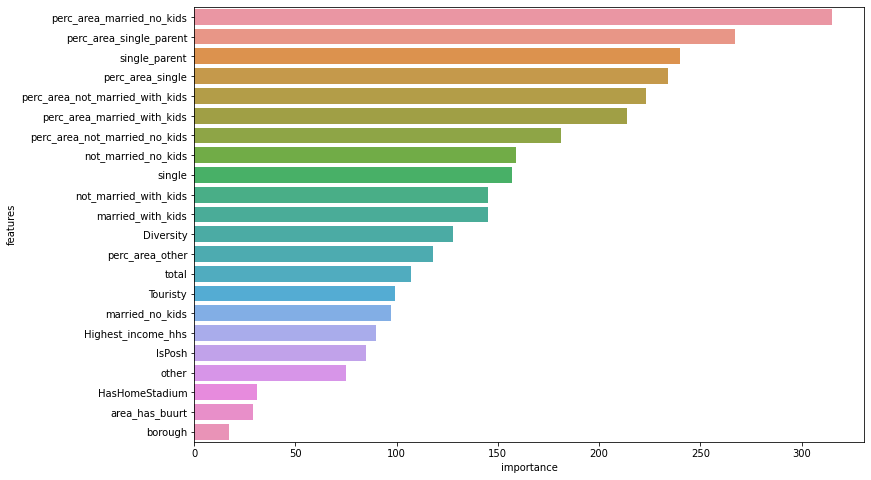

In [67]:
df_feat_imp = pd.DataFrame(
    {"features": model_features, "importance": lgb_model.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(y=df_feat_imp.features, x=df_feat_imp.importance, orient="horizontal")

### Evaluate on test data

In [68]:
test = (
    pd.read_parquet(data / "01_raw/test_raw.csv")
    .pipe(check_if_area_is_empty)
    .pipe(fill_na_values)
    .pipe(convert_dtypes)
    .pipe(get_area_borough)
    .pipe(rename_column_names)
    .pipe(get_perc_row_totals)
    .pipe(add_borough_details)
    .pipe(add_area_name_features)
)
test.head()

,area,single,married_no_kids,not_married_no_kids,married_with_kids,not_married_with_kids,single_parent,other,total,avg_woz,woz_per_msq,borough,perc_area_single,perc_area_married_no_kids,perc_area_not_married_no_kids,perc_area_married_with_kids,perc_area_not_married_with_kids,perc_area_single_parent,perc_area_other,Highest_income_hhs,Touristy,Diversity,HasHomeStadium,IsPosh,area_lower,area_has_buurt
0,F77b Noordoever Sloterplas,813.0000,125.0000,163.0000,192.0000,60.0000,121.0000,21.0000,1495.0000,164789.0000,2271.0000,Neiuw-West,54.3813,8.3612,10.9030,12.8428,4.0134,8.0936,1.4047,0,9,9,9,9,f77b noordoever sloterplas,False
1,A08e Alexanderplein e.o.,147.0000,13.0000,33.0000,15.0000,14.0000,14.0000,5.0000,241.0000,308584.0000,4078.0000,Centrum,60.9959,5.3942,13.6929,6.2241,5.8091,5.8091,2.0747,1,1,4,9,3,a08e alexanderplein e.o.,False
2,E41b Jan Maijenbuurt,827.0000,88.0000,186.0000,117.0000,43.0000,105.0000,14.0000,1380.0000,174127.0000,3018.0000,West,59.9275,6.3768,13.4783,8.4783,3.1159,7.6087,1.0145,0,2,2,9,2,e41b jan maijenbuurt,True
3,A02a Langestraat e.o.,669.0000,136.0000,157.0000,77.0000,33.0000,43.0000,10.0000,1125.0000,494103.0000,4468.0000,Centrum,59.4667,12.0889,13.9556,6.8444,2.9333,3.8222,0.8889,1,1,4,9,3,a02a langestraat e.o.,False
4,K47e Banpleinbuurt,150.0000,76.0000,29.0000,74.0000,20.0000,25.0000,2.0000,376.0000,887619.0000,4387.0000,Zuid,39.8936,20.2128,7.7128,19.6809,5.3191,6.6489,0.5319,1,1,4,9,1,k47e banpleinbuurt,True


In [69]:
test[other_cols_cat] = oe_encoder.transform(test[other_cols_cat])

y_pred = lgb_model.predict(test[model_features], num_iteration=lgb_model.best_iteration)

In [70]:
print(
    mean_absolute_error(test[TARGET], y_pred),
    mean_absolute_percentage_error(test[TARGET], y_pred),
)

60087.006940118205 0.19494263780610224


### Saving encoder and model pkl files

In [71]:
filename = "artifacts/ordinal_encoder.pkl"
pickle.dump(oe_encoder, open(filename, "wb"))

filename = "artifacts/lgb_model.pkl"
pickle.dump(lgb_model, open(filename, "wb"))